## Import

In [ ]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## Data Wrangling and Feature Preparation

In [47]:
def wrangle(db_path):
    # Connect to database
    conn = sqlite3.connect(db_path)

    # Construct query
    query = """
        SELECT distinct(i.building_id) AS b_id,
           s.*,
           d.damage_grade
        FROM id_map AS i
        JOIN building_structure AS s ON i.building_id = s.building_id
        JOIN building_damage AS d ON i.building_id = d.building_id
        WHERE district_id = 4
    """

    # Read query results into DataFrame
    df = pd.read_sql(query, conn, index_col = "b_id")

    # Identify Leaky Columns
    drop_cols = [col for col in df.columns if "post_eq" in col]

    # Create a Binary Target
    df["damage_grade"] = df["damage_grade"].str[-1].astype(int)
    df["severe_damage"] = (df["damage_grade"] > 3).astype(int)

    # Drop damage_grade (Old Target) column
    drop_cols.append("damage_grade")

    # Drop multicollinearity with less corr to target 
    drop_cols.append("count_floors_pre_eq")

    # Drop Building_id col
    drop_cols.append("building_id")

    # Drop Columns
    df.drop(columns=drop_cols, inplace=True)
    
    return df

In [48]:
df = wrangle("./Data/nepal.sqlite")
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure,severe_damage
b_id,,,,,,,,,,,,
164002,20,560,18,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164081,21,200,12,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164089,18,315,20,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164098,45,290,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0
164103,21,230,13,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,"Stone, mud mortar",0


## Explore
Since our model will be a type of linear model, we need to make sure there's no issue with multicollinearity in our dataset.

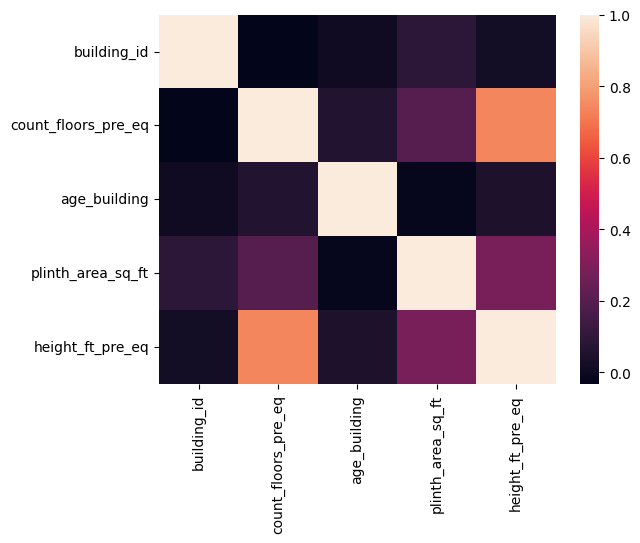

In [11]:
correlation = df.select_dtypes("number").drop(columns=["severe_damage"]).corr()
sns.heatmap(correlation);

In [ ]:
print(df["count_floors_pre_eq"].corr(df["severe_damage"]))
print(df["height_ft_pre_eq"].corr(df["severe_damage"]))

# we see that height_ft_pre_eq has a slightly higher correlation with the target, so we will drop count_floors_pre_eq

0.0028926303725752113
-0.03847659083302046


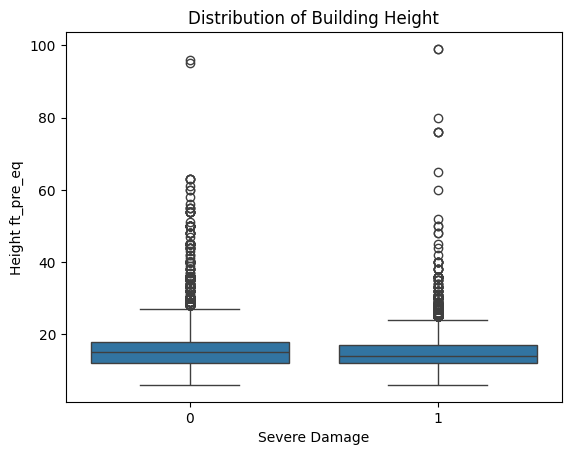

In [ ]:
sns.boxplot(x="severe_damage", y="height_ft_pre_eq", data=df)
plt.xlabel("Severe Damage")
plt.ylabel("Height ft_pre_eq")
plt.title("Distribution of Building Height");

# no worthy difference in distribution

<Axes: title={'center': 'Class Balance'}, xlabel='Class', ylabel='Freq'>

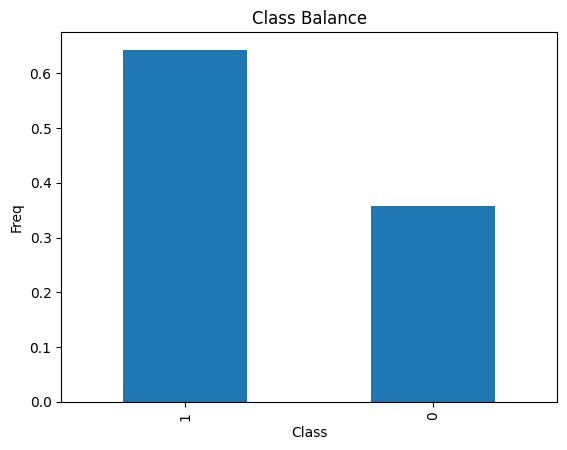

In [ ]:
df["severe_damage"].value_counts(normalize=True).plot(
    kind="bar",
    xlabel="Class",
    ylabel="Freq",
    title="Class Balance"
)

# the most common class is class 1 (severe damage) at about 65%

In [49]:
majority_class_prop, minority_class_prop = df["severe_damage"].value_counts(normalize=True)
print(f"majority class proportion (Severe Damage): {majority_class_prop:.2f}, \nminority class proportion (No Severe Damage): {minority_class_prop:.2f}")

majority class proportion (Severe Damage): 0.64, 
minority class proportion (No Severe Damage): 0.36


In [50]:
foundation_pivot = pd.pivot_table(
    df, index="foundation_type", values="severe_damage", aggfunc=np.mean
).sort_values(by="severe_damage")
foundation_pivot

# buildings with a "mud mortar with stone/brick" foundation type have the highest severe damage rate

,severe_damage
foundation_type,
RC,0.026224
Bamboo/Timber,0.324074
Cement-Stone/Brick,0.421908
Mud mortar-Stone/Brick,0.687792
Other,0.818898


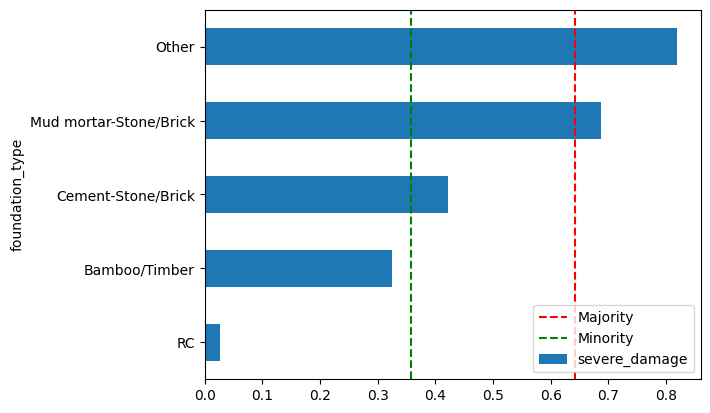

In [51]:
foundation_pivot.plot(kind="barh")
plt.axvline(
    majority_class_prop, linestyle="--", color="red", label="Majority"
)
plt.axvline(
    minority_class_prop, linestyle="--", color="green", label="Minority"
)
plt.legend(loc="lower right");

## Split Data

In [52]:
target = "severe_damage"
X = df.drop(columns=["severe_damage"])
y = df[target]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Baseline Model

In [54]:
acc_baseline = y_train.value_counts(normalize=True).max()
print("Baseline Accuracy:", round(acc_baseline, 2))

Baseline Accuracy: 0.64


## Logistic Regression Model

### Iterate

In [55]:
lr_model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    LogisticRegression(max_iter=1000, random_state=42)
)
lr_model.fit(X_train, y_train)

d:\Machine Learning Projects\Earthquake Damage in Nepal\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('onehotencoder', ...), ('logisticregression', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,verbose,0
,cols,"['land_surface_condition', 'foundation_type', ...]"
,drop_invariant,False
,return_df,True
,handle_missing,'value'
,handle_unknown,'value'
,use_cat_names,True


### Evaluate

In [56]:
acc_train = accuracy_score(y_train, lr_model.predict(X_train))
acc_test = lr_model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 2))
print("Test Accuracy:", round(acc_test, 2))

# our model is performing better than the baseline
# good for a first try

Training Accuracy: 0.71
Test Accuracy: 0.72


### Communicate

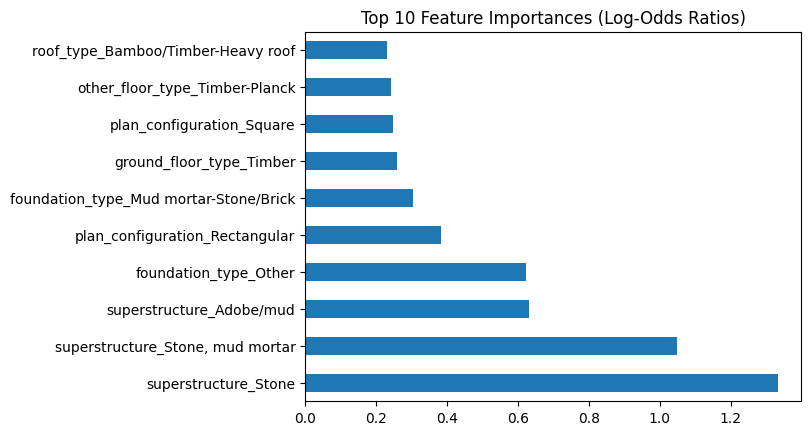

In [57]:
# Compute feature importances
features = lr_model.named_steps["onehotencoder"].get_feature_names()
importances = lr_model.named_steps["logisticregression"].coef_[0]

odds_ratios = pd.Series(importances, index=features).sort_values(ascending=False)
odds_ratios.head(10).plot(kind="barh")
plt.title("Top 10 Feature Importances (Log-Odds Ratios)");

## Decision Tree Model

### Split data again for validation

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

### Iterate

In [59]:
dt_model = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(random_state=42)
)
dt_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('ordinalencoder', ...), ('decisiontreeclassifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,verbose,0
,mapping,"[{'col': 'land_surface_condition', 'data_type': dtype('O'), 'mapping': Flat ...2 dtype: int64}, {'col': 'foundation_type', 'data_type': dtype('O'), 'mapping': Mud mortar-St...2 dtype: int64}, ...]"
,cols,"['land_surface_condition', 'foundation_type', ...]"
,drop_invariant,False
,return_df,True
,handle_unknown,'value'
,handle_missing,'value'


In [60]:
acc_train = accuracy_score(y_train, dt_model.predict(X_train))
acc_val = dt_model.score(X_val ,y_val)

print("Training Accuracy:", round(acc_train, 2))
print("Validation Accuracy:", round(acc_val, 2))

# our decision tree is overfitting the training data

Training Accuracy: 0.98
Validation Accuracy: 0.65


In [61]:
tree_depth = dt_model.named_steps["decisiontreeclassifier"].get_depth()
print("Tree Depth:", tree_depth)

# The tree depth is quite high, indicating overfitting. We may need to tune hyperparameters to improve generalization.

Tree Depth: 49


In [62]:
depth_hyperparams = range(1, 50, 2)

training_acc = []
validation_acc = []

for d in depth_hyperparams:

    test_model = make_pipeline(
        OrdinalEncoder(),
        DecisionTreeClassifier(max_depth=d, random_state=42)
    )

    test_model.fit(X_train, y_train)
    training_acc.append(test_model.score(X_train, y_train)) 
    validation_acc.append(test_model.score(X_val, y_val))

print("Training Accuracy Scores:", training_acc[:3])
print("Validation Accuracy Scores:", validation_acc[:3])


Training Accuracy Scores: [0.7071072484228174, 0.7117395332421582, 0.7162394670666608]
Validation Accuracy Scores: [0.7088406564319746, 0.7132521616375508, 0.7166049055937886]


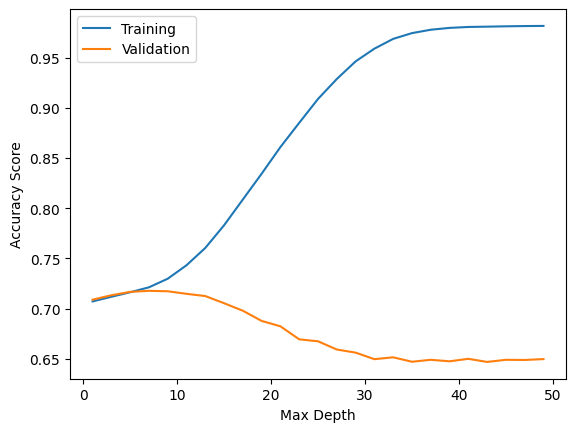

In [63]:
plt.plot(depth_hyperparams, training_acc, label="Training")
plt.plot(depth_hyperparams, validation_acc, label="Validation")
plt.xlabel("Max Depth")
plt.ylabel("Accuracy Score")
plt.legend();

# From the plot, we can choose a max_depth that balances bias and variance. A max_depth of around 7 seems to provide a good trade-off.

In [64]:
dt_best_model = make_pipeline(
    OrdinalEncoder(),
    DecisionTreeClassifier(max_depth=7, random_state=42)
)
dt_best_model.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('ordinalencoder', ...), ('decisiontreeclassifier', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,verbose,0
,mapping,"[{'col': 'land_surface_condition', 'data_type': dtype('O'), 'mapping': Flat ...2 dtype: int64}, {'col': 'foundation_type', 'data_type': dtype('O'), 'mapping': Mud mortar-St...2 dtype: int64}, ...]"
,cols,"['land_surface_condition', 'foundation_type', ...]"
,drop_invariant,False
,return_df,True
,handle_unknown,'value'
,handle_missing,'value'


In [65]:
train_acc = dt_best_model.score(X_train, y_train)
val_acc = dt_best_model.score(X_val, y_val)
print(f"Train Accuracy: {train_acc}")
print(f"Val Accuracy: {val_acc}")

# The tuned decision tree shows improved validation accuracy, indicating better generalization.

Train Accuracy: 0.721158512374818
Val Accuracy: 0.7176636668431269


### Final Test on DT

In [66]:
test_acc = dt_best_model.score(X_test, y_test)
print("Test Accuracy:", round(test_acc, 2))

# The test accuracy is satisfactory and indicates that our tuned decision tree model generalizes well to unseen data.

Test Accuracy: 0.72


### Communicate

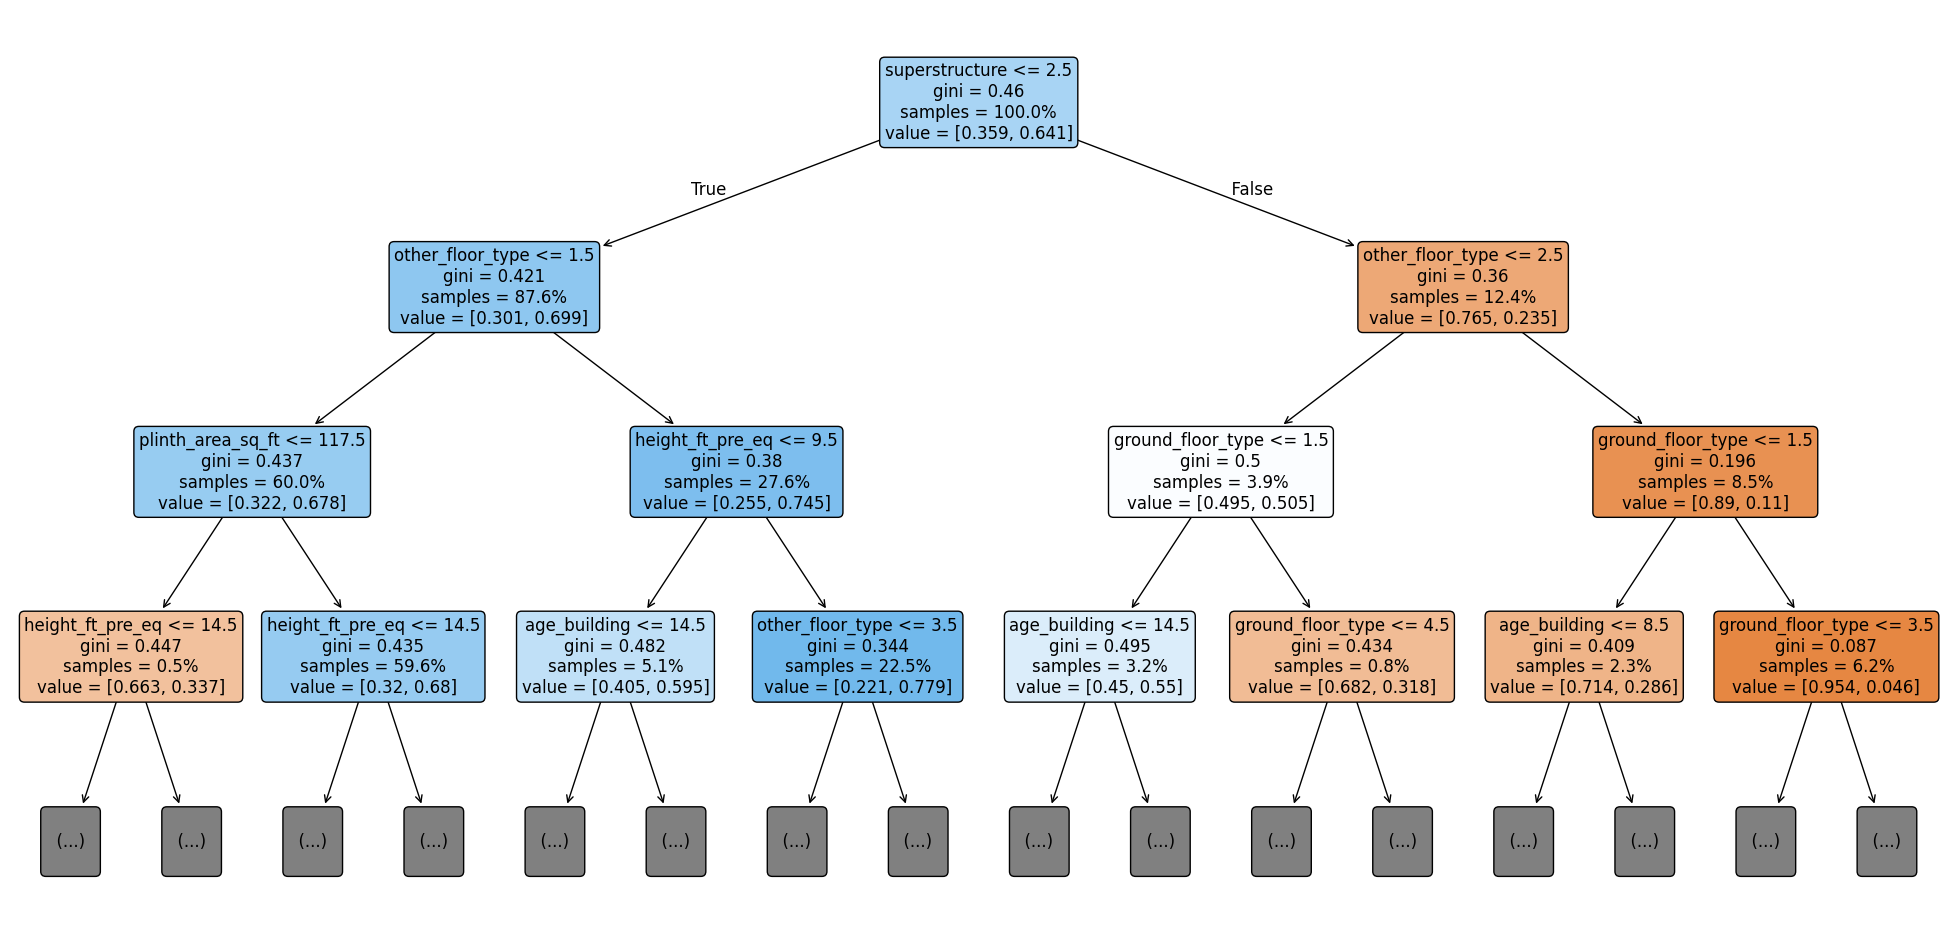

In [67]:
fig, ax = plt.subplots(figsize=(25, 12))

plot_tree(
    decision_tree = dt_best_model.named_steps["decisiontreeclassifier"],
    feature_names = X_train.columns.to_list() ,
    filled=True,  
    rounded=True,  
    proportion=True,  
    max_depth=3,  
    fontsize=12,  
    ax=ax,  
);

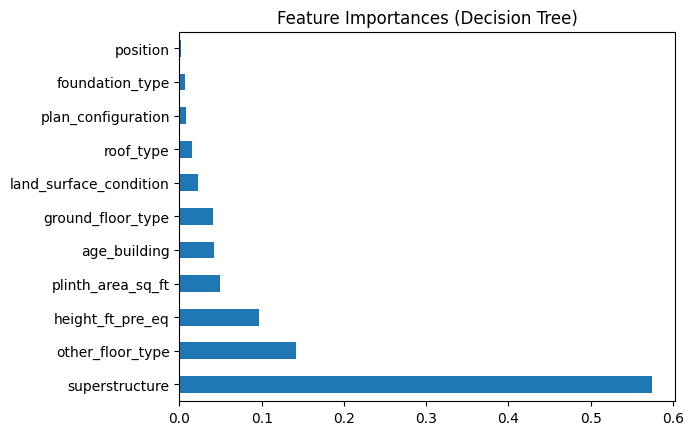

In [68]:
features = X_train.columns
importances = dt_best_model.named_steps["decisiontreeclassifier"].feature_importances_

feat_imp = pd.Series(
    data=importances,
    index=features
).sort_values(ascending=False).plot(kind="barh")
plt.title("Feature Importances (Decision Tree)");

## Model Selection Rationale

Multiple classification models were evaluated to balance predictive performance, interpretability, and robustness.

- **Logistic Regression** was used as a baseline linear model to establish a simple and interpretable performance benchmark.

- **Decision Tree Classifier** was explored to capture non-linear relationships and feature interactions that linear models may fail to represent.

This comparative approach allows assessment of trade-offs between model complexity, interpretability, and predictive accuracy.


## Conclusion
This project demonstrates an end-to-end data science workflow for predicting severe building damage following an earthquake using pre-event structural characteristics.

The analysis included data extraction from a relational database, careful feature selection to prevent data leakage, target engineering, and evaluation of multiple classification models. Results indicate that tree-based is effective at capturing non-linear relationships inherent in structural damage data, while simpler models provide valuable interpretability baselines.

Future work may include more advanced feature selection, hyperparameter tuning, alternative evaluation metrics focused on class imbalance, and model deployment considerations for real-world disaster response applications.
